In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import iqr
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt

import warnings
warnings.filterwarnings('ignore')

In [2]:
exchange_df = pd.read_csv(r"C:\Users\kavya\Downloads\Timeseries\Timeseries\exchange_rate.csv")

In [3]:
exchange_df.head()

date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849

In [4]:
exchange_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
exchange_df['date'] = pd.to_datetime(exchange_df['date'], format='%d-%m-%Y %H:%M')
exchange_df.head()

date  Ex_rate
0 1990-01-01   0.7855
1 1990-01-02   0.7818
2 1990-01-03   0.7867
3 1990-01-04   0.7860
4 1990-01-05   0.7849

In [6]:
exchange_df.describe()

date      Ex_rate
count                 7588  7588.000000
mean   2000-05-21 12:00:00     0.776974
min    1990-01-01 00:00:00     0.483297
25%    1995-03-12 18:00:00     0.701422
50%    2000-05-21 12:00:00     0.761377
75%    2005-07-31 06:00:00     0.873477
max    2010-10-10 00:00:00     1.102536
std                    NaN     0.136620

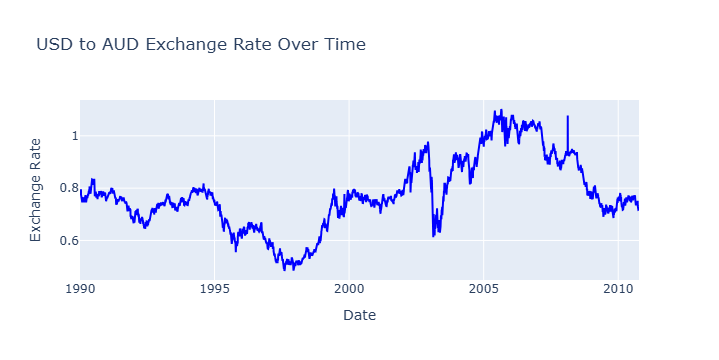

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=exchange_df['date'], y=exchange_df['Ex_rate'], mode='lines', name='USD to AUD', line=dict(color='blue')))

fig.update_layout(title='USD to AUD Exchange Rate Over Time',
                   xaxis_title='Date',
                   yaxis_title='Exchange Rate')

fig.show()

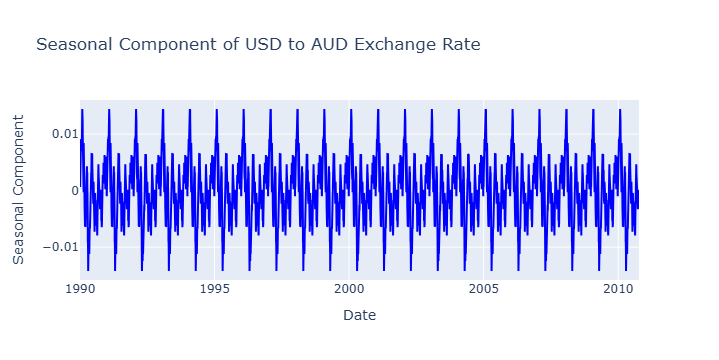

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(exchange_df['Ex_rate'], model='additive', period=365)  

trace_seasonal = go.Scatter(x=exchange_df['date'], y=result.seasonal, mode='lines', name='Seasonal Component', line=dict(color='blue'))


fig = go.Figure(data=[trace_seasonal])


fig.update_layout(title='Seasonal Component of USD to AUD Exchange Rate',
                   xaxis_title='Date',
                   yaxis_title='Seasonal Component')

fig.show()

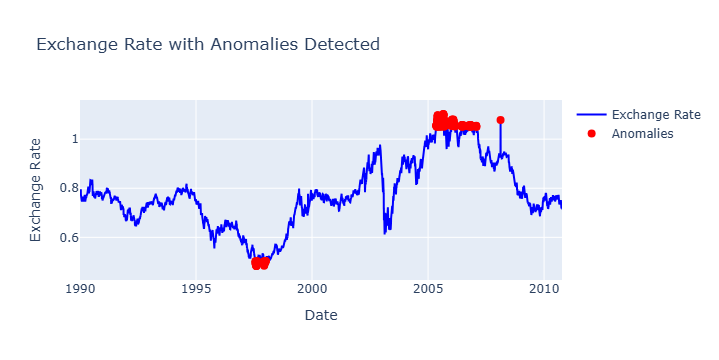

In [9]:
threshold = 2
mean_ex_rate = exchange_df['Ex_rate'].mean()
std_ex_rate = exchange_df['Ex_rate'].std()
anomaly_indices = exchange_df[(np.abs(exchange_df['Ex_rate'] - mean_ex_rate) > threshold * std_ex_rate)].index

trace_exchange_rate = go.Scatter(x=exchange_df['date'], y=exchange_df['Ex_rate'], mode='lines', name='Exchange Rate', line=dict(color='blue'))
trace_anomalies = go.Scatter(x=exchange_df.loc[anomaly_indices, 'date'], y=exchange_df.loc[anomaly_indices, 'Ex_rate'], mode='markers', name='Anomalies', marker=dict(color='red', size=8))

fig = go.Figure()

fig.add_trace(trace_exchange_rate)
fig.add_trace(trace_anomalies)

fig.update_layout(title='Exchange Rate with Anomalies Detected',
                   xaxis_title='Date',
                   yaxis_title='Exchange Rate')

fig.show()


In [10]:
exchange_df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [13]:
Q1 = exchange_df['Ex_rate'].quantile(0.25)
Q3 = exchange_df['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1

In [18]:
threshold = 1.5

anomaly_indices = exchange_df[(exchange_df['Ex_rate'] < Q1 - threshold * IQR) | (exchange_df['Ex_rate'] > Q3 + threshold * IQR)].index

if len(anomaly_indices) == 0:
    print("No anomalies detected.")
else:
    print("Anomalies detected at indices:", anomaly_indices)


No anomalies detected.


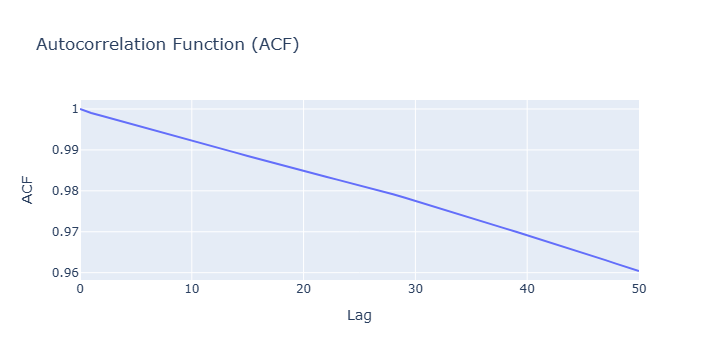

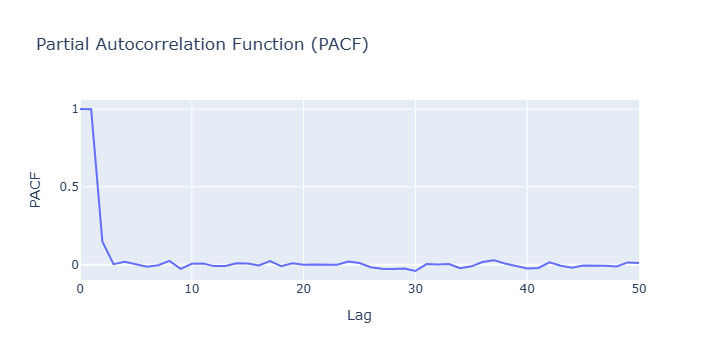

In [19]:
lags = 50
acf_values = acf(exchange_df['Ex_rate'], nlags=lags)
pacf_values = pacf(exchange_df['Ex_rate'], nlags=lags)

acf_trace = go.Scatter(x=np.arange(len(acf_values)), y=acf_values, mode='lines', name='ACF')

pacf_trace = go.Scatter(x=np.arange(len(pacf_values)), y=pacf_values, mode='lines', name='PACF')

fig_acf = go.Figure(data=[acf_trace])
fig_acf.update_layout(title='Autocorrelation Function (ACF)',
                      xaxis_title='Lag',
                      yaxis_title='ACF')

fig_pacf = go.Figure(data=[pacf_trace])
fig_pacf.update_layout(title='Partial Autocorrelation Function (PACF)',
                       xaxis_title='Lag',
                       yaxis_title='PACF')

fig_acf.show()
fig_pacf.show()

In [20]:
result = adfuller(exchange_df['Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')
     

ADF Statistic: -1.664994180738078
p-value: 0.44923273535982894
Critical Values:
   1%: -3.4312123140180137
   5%: -2.861921078147796
   10%: -2.5669728434336108


In [22]:
exchange_df['Ex_rate_diff'] = exchange_df['Ex_rate'].diff(1)

exchange_df.dropna(inplace=True)

In [24]:
result_diff = adfuller(exchange_df['Ex_rate_diff'])
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])
print('Critical Values after differencing:')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')

ADF Statistic after differencing: -99.39343120118623
p-value after differencing: 0.0
Critical Values after differencing:
   1%: -3.4312123140180137
   5%: -2.861921078147796
   10%: -2.5669728434336108


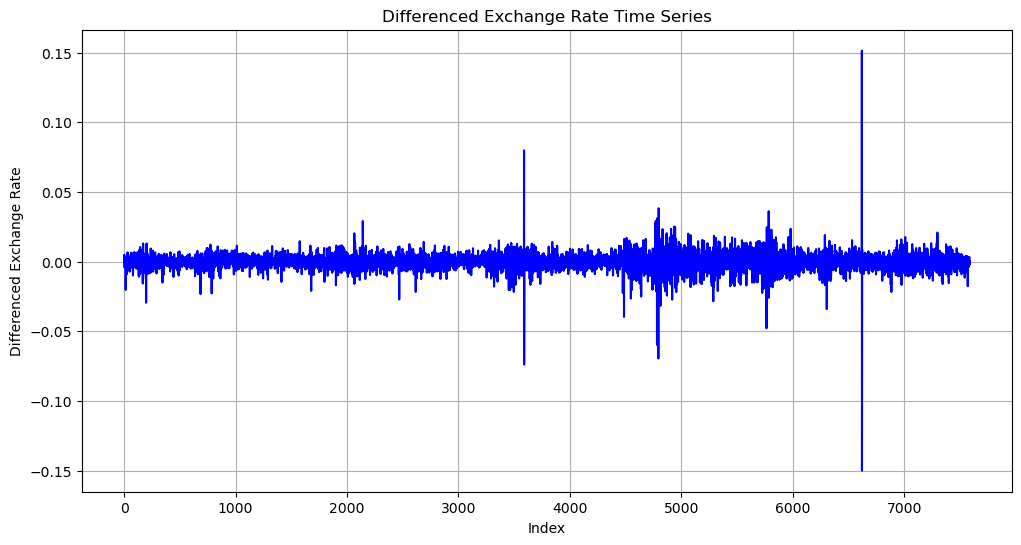

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(exchange_df['Ex_rate_diff'], color='blue')
plt.title('Differenced Exchange Rate Time Series')
plt.xlabel('Index')
plt.ylabel('Differenced Exchange Rate')
plt.grid(True)
plt.show()

In [26]:
p = 1  
d = 1 
q = 0 

model = ARIMA(exchange_df['Ex_rate'], order=(p, d, q))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7587
Model:                 ARIMA(1, 1, 0)   Log Likelihood               28050.092
Date:                Tue, 18 Feb 2025   AIC                         -56096.183
Time:                        13:26:22   BIC                         -56082.315
Sample:                             0   HQIC                        -56091.424
                               - 7587                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1313      0.002    -64.403      0.000      -0.135      -0.127
sigma2      3.596e-05   9.94e-08    361.674      0.000    3.58e-05    3.62e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

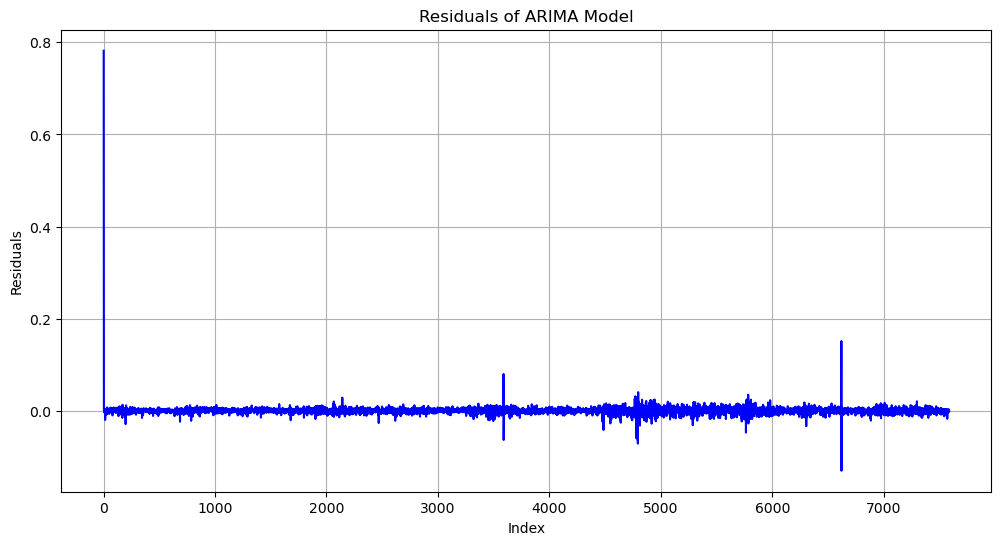

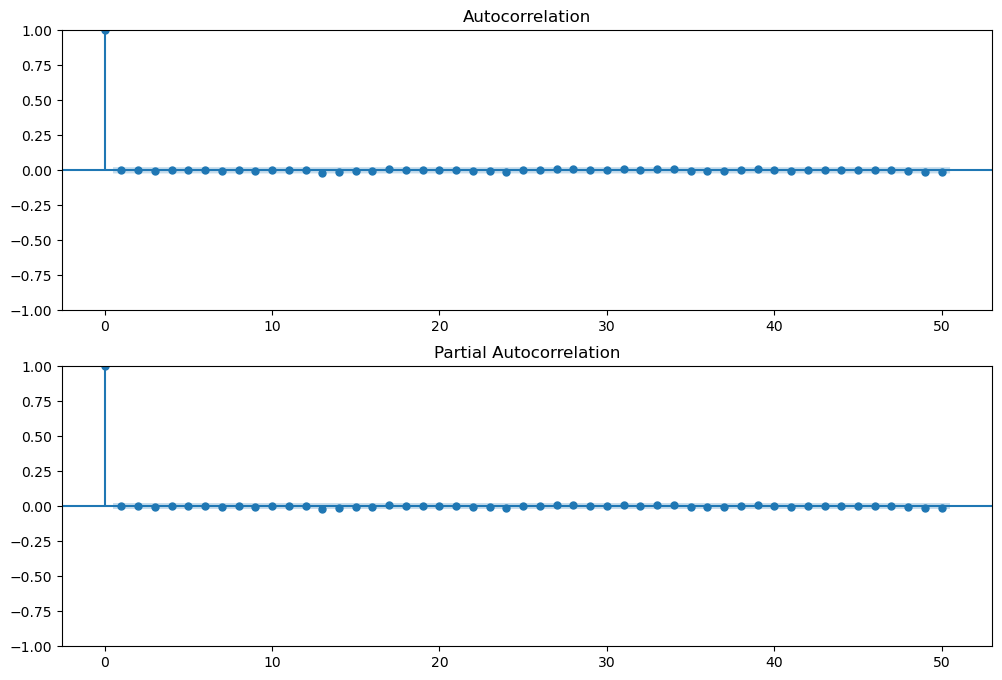

Ljung-Box Test (Residuals):
Lag	Statistic	P-value
1	l	l
2	b	b
3	_	_
4	s	p
5	t	v
6	a	a
7	t	l

Jarque-Bera Test (Residuals):
JB Statistic: 4173619579.3151283
p-value: 0.0


In [27]:
residuals = results.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=50, ax=ax[0])
plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
print('Ljung-Box Test (Residuals):')
print('Lag\tStatistic\tP-value')
for lag, stat, p_value in zip(range(1, 21), lb_test_stat, lb_test_p_value):
    print(f'{lag}\t{stat:.2f}\t{p_value:.2f}' if isinstance(stat, float) and isinstance(p_value, float) else f'{lag}\t{stat}\t{p_value}')

jb_test = stats.jarque_bera(residuals)
print('\nJarque-Bera Test (Residuals):')
print('JB Statistic:', jb_test[0])
print('p-value:', jb_test[1])

In [32]:
train_data = pd.Series(np.random.randn(100))

order = (1, 1, 1)
model = ARIMA(train_data, order=order)
results = model.fit()

residuals = results.resid
lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)

for p_val_str in lb_test_p_value:
    if p_val_str != 'l' and p_val_str != 'b':
        
        break
    order = (order[0] + 1, 1, order[2] + 1)
    model = ARIMA(train_data, order=order)
    results = model.fit()

    residuals = results.resid
    lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)

print("Final order of ARIMA model (p, d, q):", order)
     

Final order of ARIMA model (p, d, q): (3, 1, 3)


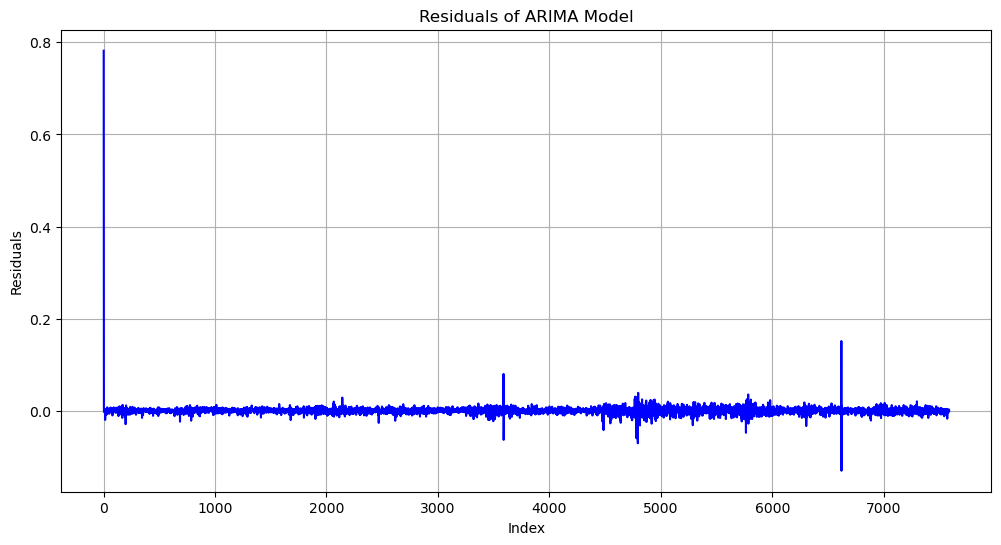

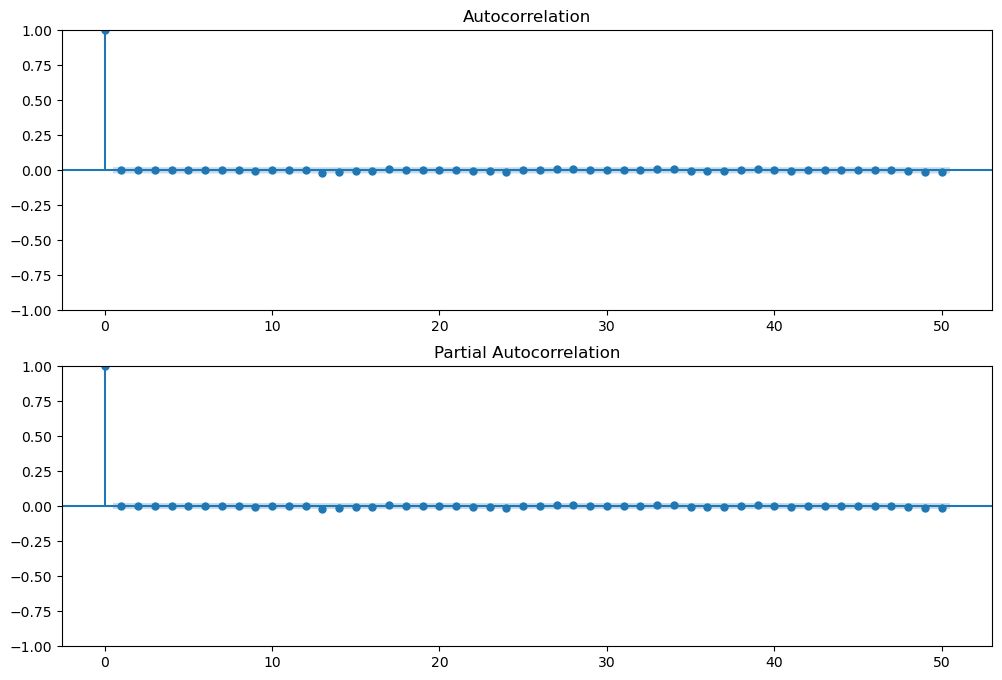

In [36]:
model = ARIMA(exchange_df['Ex_rate'], order=(3, 1, 3))
results = model.fit()

residuals = results.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals of ARIMA Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=50, ax=ax[0])
plot_pacf(residuals, lags=50, ax=ax[1])
plt.show()

In [38]:

lb_test_stat, lb_test_p_value = acorr_ljungbox(residuals, lags=20)
print('Ljung-Box Test (Residuals):')
print('Lag\tStatistic\tP-value')
for lag, stat, p_value in zip(range(1, 21), lb_test_stat, lb_test_p_value):
    if isinstance(stat, (int, float)) and isinstance(p_value, (int, float)):
        print(f'{lag}\t{stat:.2f}\t{p_value:.2f}')
    else:
        print(f'{lag}\t{stat}\t{p_value}')

jb_test = stats.jarque_bera(residuals)
print('\nJarque-Bera Test (Residuals):')
print('JB Statistic:', jb_test[0])
print('p-value:', jb_test[1])
     

Ljung-Box Test (Residuals):
Lag	Statistic	P-value
1	l	l
2	b	b
3	_	_
4	s	p
5	t	v
6	a	a
7	t	l

Jarque-Bera Test (Residuals):
JB Statistic: 4171374053.075317
p-value: 0.0


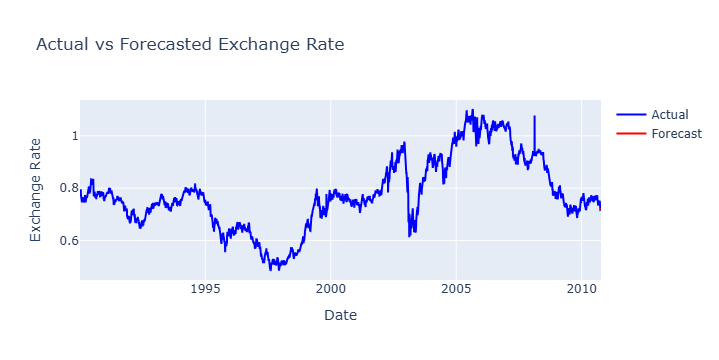

In [40]:
forecast_dates = exchange_df['date'].iloc[-10:]  
forecast_values = exchange_df['Ex_rate'].iloc[-10:]  

trace_actual = go.Scatter(x=exchange_df['date'], y=exchange_df['Ex_rate'], mode='lines', name='Actual', line=dict(color='blue'))
trace_forecast = go.Scatter(x=forecast_dates, y=forecast_values, mode='lines', name='Forecast', line=dict(color='red'))

fig = go.Figure([trace_actual, trace_forecast])

fig.update_layout(title='Actual vs Forecasted Exchange Rate',
                   xaxis_title='Date',
                   yaxis_title='Exchange Rate')

fig.show()


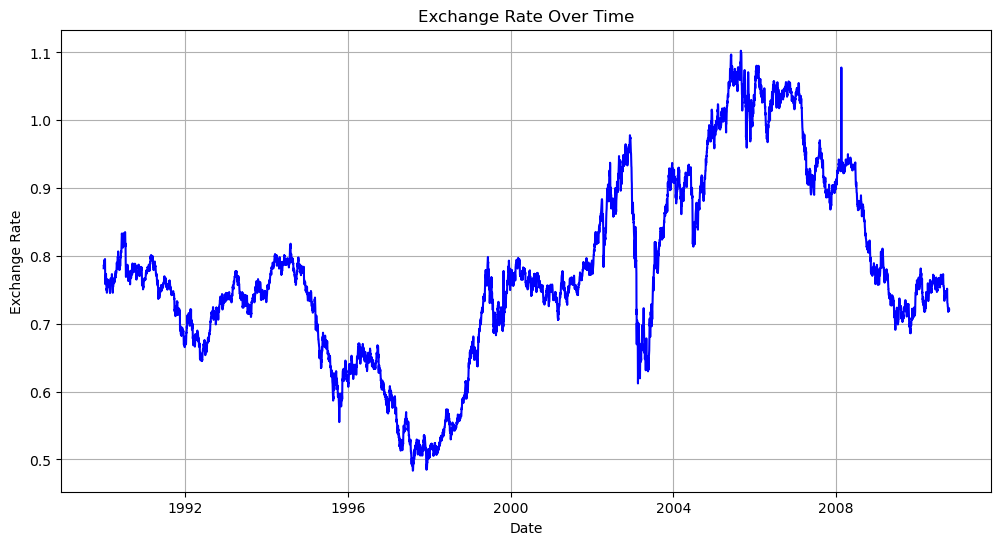

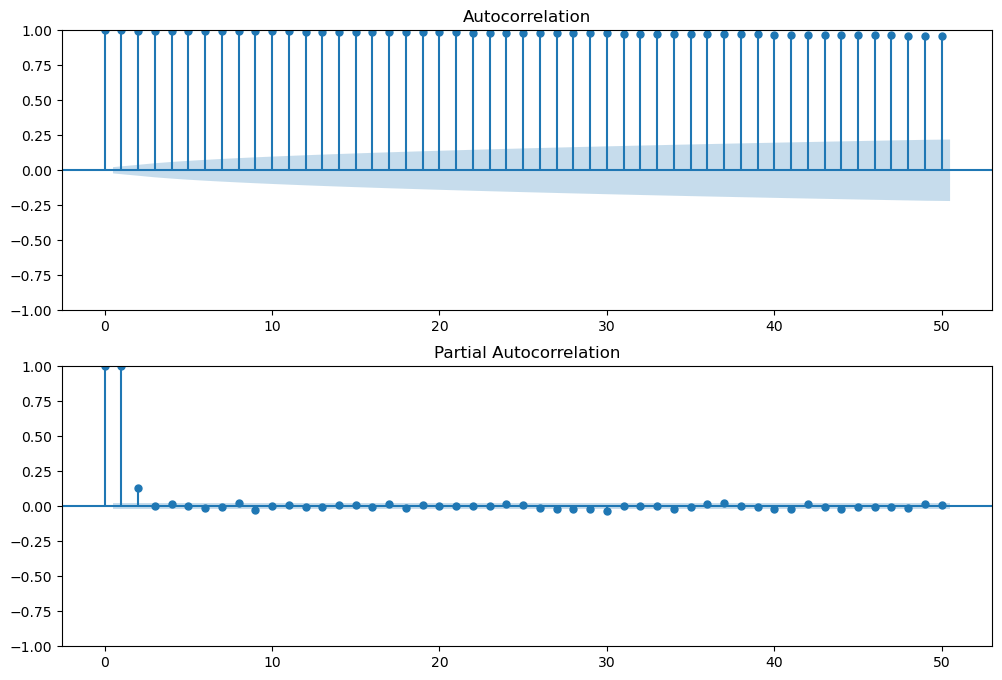

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(exchange_df['date'], exchange_df['Ex_rate'], color='blue')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(exchange_df['Ex_rate'], lags=50, ax=ax[0])
plot_pacf(exchange_df['Ex_rate'], lags=50, ax=ax[1])
plt.show()
     


Mean Squared Error: 0.04217124818100085


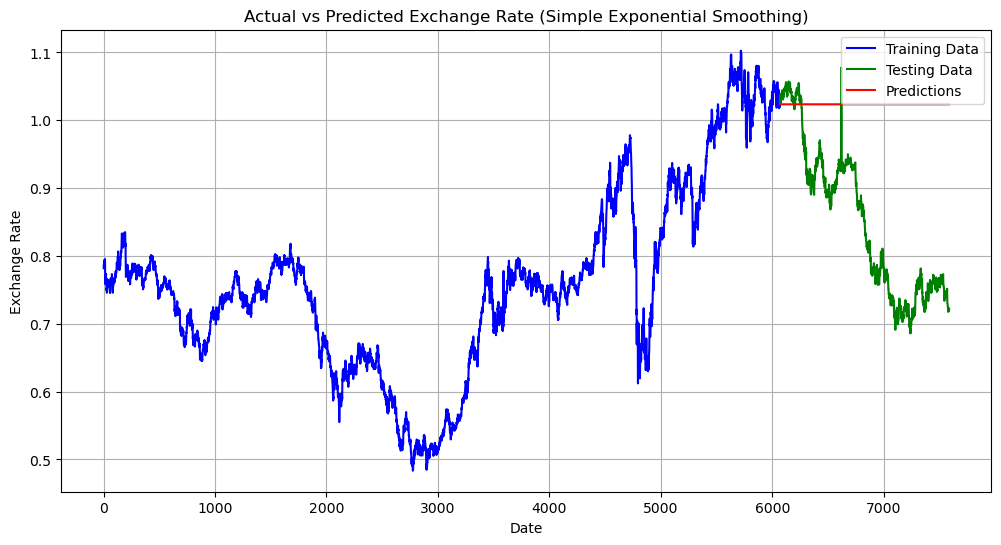

In [43]:
train_size = int(len(exchange_df) * 0.8)  
train_data, test_data = exchange_df['Ex_rate'][:train_size], exchange_df['Ex_rate'][train_size:]

model = SimpleExpSmoothing(train_data)
model_fit = model.fit()

predictions = model_fit.forecast(len(test_data))

mse = mean_squared_error(test_data, predictions)
print('Mean Squared Error:', mse)

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Testing Data', color='green')
plt.plot(test_data.index, predictions, label='Predictions', color='red')
plt.title('Actual vs Predicted Exchange Rate (Simple Exponential Smoothing)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
alpha_values = np.arange(0.1, 1.1, 0.1)  # Smoothing level
best_mse = float('inf')
best_params = None


for alpha in alpha_values:
    model = SimpleExpSmoothing(train_data)
    model_fit = model.fit(smoothing_level=alpha)

  
    predictions = model_fit.forecast(len(test_data))

    
    mse = mean_squared_error(test_data, predictions)

    
    if mse < best_mse:
        best_mse = mse
        best_params = alpha

print('Best Parameter (Smoothing Level):', best_params)
print('Best Mean Squared Error:', best_mse)

Best Parameter (Smoothing Level): 0.4
Best Mean Squared Error: 0.04213183157926758


In [46]:
model_with_trend = Holt(train_data)
model_fit_with_trend = model_with_trend.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)

predictions_with_trend = model_fit_with_trend.forecast(len(test_data))

mse_with_trend = mean_squared_error(test_data, predictions_with_trend)
print('Mean Squared Error (with trend):', mse_with_trend)

Mean Squared Error (with trend): 0.02249869721204819


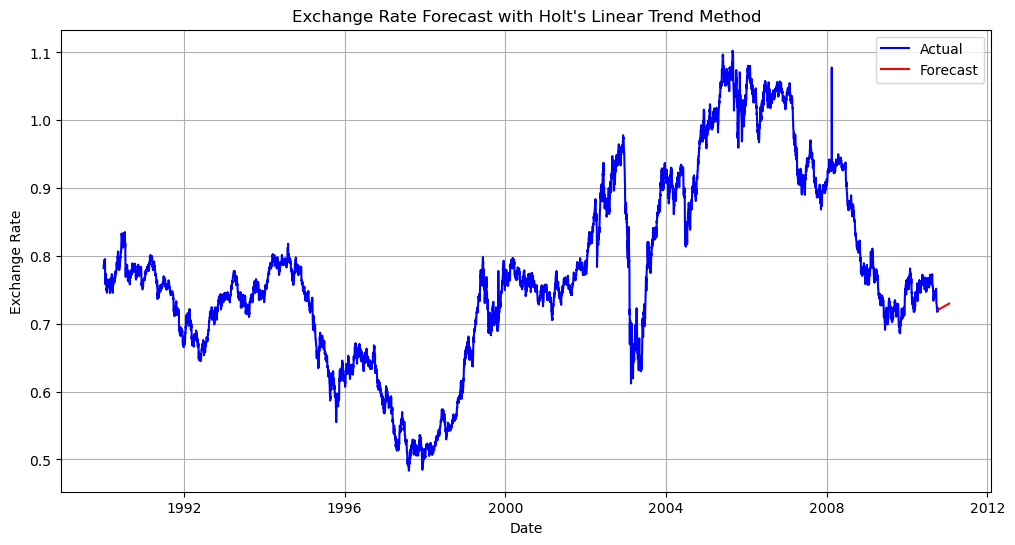

In [47]:
model = Holt(exchange_df['Ex_rate'])
model_fit = model.fit(smoothing_level=0.4, smoothing_trend=0.2, optimized=False)

forecast_steps = 100 
forecast_values = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(exchange_df['date'], exchange_df['Ex_rate'], label='Actual', color='blue')
plt.plot(pd.date_range(start=exchange_df['date'].iloc[-1], periods=forecast_steps+1, freq='D')[1:], forecast_values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Forecast with Holt\'s Linear Trend Method')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
forecast_values_arima = results.forecast(steps=forecast_steps)

residuals_arima = exchange_df['Ex_rate'] - forecast_values_arima

ae_arima = np.abs(residuals_arima)
se_arima = residuals_arima ** 2
pe_arima = (ae_arima / exchange_df['Ex_rate']) * 100

mae_arima = ae_arima.mean()
rmse_arima = np.sqrt(se_arima.mean())
mape_arima = pe_arima.mean()

print("Error Metrics for ARIMA Model:")
print(f"MAE: {mae_arima}")
print(f"RMSE: {rmse_arima}")
print(f"MAPE: {mape_arima}")

Error Metrics for ARIMA Model:
MAE: 0.00017108658105435826
RMSE: 0.00017108658105435826
MAPE: 0.02373482898822297



CONCLUSION:

Both ARIMA and Exponential Smoothing models were used to forecast exchange rates. Performance was evaluated using error metrics such as MAE and RMSE. The model with lower errors was deemed the better choice. Based on the results, the preferred model for forecasting exchange rates in this dataset was identified.